In [1]:
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
from numpy.linalg import inv

%matplotlib inline

# I) Example of "supervised discriminative model": the Logistic regression

In [2]:
# load data

#datadir = '/home/mastermind/Documents/machine_learning_tuto/data'
datadir = '/Users/fongngo/Documents/ML_short_demo/data'

# datadir = osp.dirname(__file__)

train_name = 'classificationA.train.txt'
test_name = 'classificationA.test.txt'
traindata = osp.join(datadir, train_name) 
testdata = osp.join(datadir, test_name)
Xy_train = np.loadtxt(traindata) 
Xy_test = np.loadtxt(testdata)
X_train = Xy_train[:, :2] 
y_train = Xy_train[:, 2]
X_test = Xy_test[:, :2]
y_test = Xy_test[:, 2]
del Xy_train
del Xy_test

### Model:


$\mathbb{P}(Y=1|X=x) = \sigma(w^T x)$

$Y|X=x \sim \text{Ber}(\sigma(w^T x))$

In particular, linear dependance of $Y$ with relation to $X$

### Learning : 

Finding optimal $w$:

Training dataset $(x_i, y_i)_{1<=i<=N}$ (sample), assumed IID
$y_i \in \{0, 1\}$, $x \in \mathbb{R}^p$


Several ways to see the optimal value for the weights $w^*$:
- Find the maximum likelihood estimator
- Minimize a loss criteria (fit the model to the data)

We will see that both approaches result to the same quantity to minimize.

### Loglikelihood maximization:


Idea: find the model (find $w$) such that our data are quite likely ones / quite realistic / likely to be generated by our model.  

$l(w)= \log \prod_i p(y_i | x_i, w)$

$   = \sum_i y_i \log {\eta_i} + (1-y_i) \log (1-\eta_i) $
Called cross-entropy (nega.

With $\eta_i=\sigma(w^T x)$

Differentiable and concave. But no closed form for $w^*$. Need an optimization procedure, that is an algorithm able to find an optimal value (here we want to find $w^* = \underset{w}{\arg\max}\  l(w)$

Algorithm we are gonna use: Newton descent, because it is fast and there is a nice interpretation (Often called Iterative Reweighted Least Squares): 

$w^{(t+1)} = w^{(t)} - \nabla^2 l(w^{(t)})^{-1} \nabla l(w^{(t)})$

Computations:

Gradient: $\nabla l = \sum_i (y_i - \eta_i)x_i = X^{T}(y-\eta)$

Hessienne: $\nabla^2 l = - \sum_i \eta_i (1-\eta_i) x_i {x_i}^{T} = - X^T S X$,  with $S = \text{diag}(\eta_i (1-\eta_i)_{1:N})$


Finally we obtain:

$w^{(t+1)} = (X^T S^{(t)} X)^{-1} X^T S^{(t)}z^{(t)}$ with $z^{(t)}=Xw^{(t)} + (S^{(t)})^{-1}(y-\eta^{(t)})$

Idea: solve a reweighted least squares problem at each iteration = IRLS

### Implementation

In [3]:
def logistic(u):
    return 1 / (1 + np.exp(-u)) # note: logistic function is always positive (> 0)

In [4]:
def loglikelihood(X, y, w):
    eta = logistic(X.dot(w))
    return np.sum(y*np.log(eta) + (1-y)*np.log(1-eta))

In [5]:
def fitLogisticRegression(X, y, niter):
    """
    inputs:
    X: samples, n x (p+1)
    y: labels (target variable), n x 1 
    niter: number of iterations
    
    output:
    optimal parameter vector w
    """
    _, dim = X.shape
    w = np.zeros((dim, 1)) # initialization, (p+1) x 1
    loglkhd = np.zeros((niter, 1))
    for i in xrange(niter):
        mu = np.squeeze(X.dot(w)) # value of w is updated during each iteration
        eta = logistic(mu)
        s = eta * (1 - eta)
        z = mu + (y - eta) / s # because S is a diagonal matrix
        S = np.diag(s)
        w = inv((X.T).dot(S).dot(X)).dot(X.T).dot(S).dot(z)
        loglkhd[i] = loglikelihood(X, y, w)
    return w, loglkhd

In [6]:
# first add a column of 1s to take the bias into account
nrows_train, _ = X_train.shape
nrows_test, _ = X_test.shape
X_train = np.concatenate((X_train, np.ones((nrows_train, 1))), axis=1)
X_test = np.concatenate((X_test, np.ones((nrows_test, 1))), axis=1)

# Learning: fit model on data
w_opt, loglkhd_values = fitLogisticRegression(X_train, y_train, 8)
# apply the optimal model on test dataset:
predictions = np.where(logistic(X_test.dot(w_opt))>0.5, 1, 0)
classification_rate = float(sum(predictions==y_test))/len(y_test)

In [7]:
classification_rate

0.9673333333333334

In [8]:
is_1 = y_test == 1
is_0 = y_test == 0
X_test_1 = X_test[is_1]
X_test_0 = X_test[is_0]

# false predictions
is_false = predictions != y_test
X_false = X_test[is_false]

In [9]:
def get_separation(w, xmin, xmax, npoints=2):
    """
    Get coordinates of points on the linear seperation (w.dot(x)=0)
    """
    xcoord = np.linspace(xmin, xmax, npoints)
    # ycoord = -(w[1]*xcoord + w[2]) / w[0]
    ycoord = -(w[0]*xcoord + w[2]) / w[1]

    return xcoord, ycoord

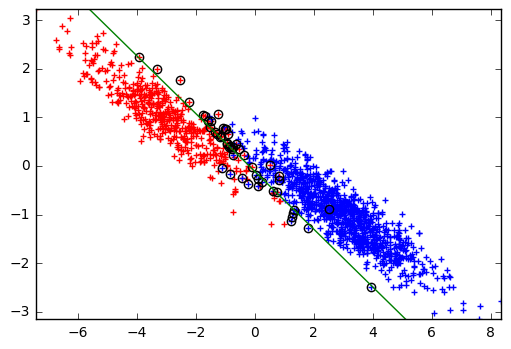

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_test_1[:, 0], X_test_1[:, 1], c='r', marker='+')
ax.scatter(X_test_0[:, 0], X_test_0[:, 1], c='b', marker='+')
ax.plot(X_false[:, 0], X_false[:, 1], c='k', 
        marker='o', linestyle='None', 
        fillstyle='none', markeredgewidth='1')  # false predictions
xmin, xmax = min(X_test[:, 0]), max(X_test[:, 0])
ymin, ymax = min(X_test[:, 1]), max(X_test[:, 1])
xsep, ysep = get_separation(w_opt, xmin, xmax) # beware, linear separation originated from training set !
ax.plot(xsep, ysep, c='g')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
#plt.axis('equal')


plt.show()

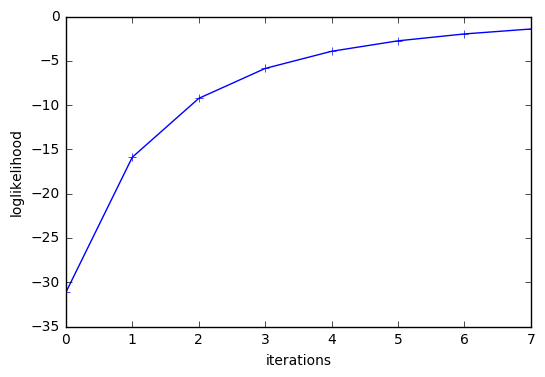

In [11]:
# print loglikelihood. Expected to be maximized
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(8), loglkhd_values, marker='+')
ax.set_xlabel('iterations')
ax.set_ylabel('loglikelihood')
